In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os 
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
!pip install jdatetime
import jdatetime
from datetime import datetime

***
Train and test set

In [ ]:
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('output.csv')
df = pd.concat([df_train, df_test], axis = 0, ignore_index=True)
df.head()

,date,sale
0,1399-05-30,384.0
1,1399-05-31,393.0
2,1399-06-01,414.0
3,1399-06-02,410.0
4,1399-06-03,398.0


In [ ]:
df = pd.concat([df['date'].str.split('-', expand=True), 
                df['sale']], 
               axis=1)

df.columns = ['year', 'month', 'day', 'sale']
df.tail()

,year,month,day,sale
139,1399,10,17,NaN
140,1399,10,18,NaN
141,1399,10,19,NaN
142,1399,10,20,NaN
143,1399,10,21,NaN


In [ ]:
df['date'] = ''
for i in range(0,df.shape[0]): 
  df['date'][i] = jdatetime.date(int(df['year'][i]),
                                 int(df['month'][i]),
                                 int(df['day'][i])
                                 ).togregorian()
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,month,day,sale,date
0,1399,05,30,384.0,2020-08-20
1,1399,05,31,393.0,2020-08-21
2,1399,06,01,414.0,2020-08-22
3,1399,06,02,410.0,2020-08-23
4,1399,06,03,398.0,2020-08-24


In [ ]:
df.dtypes

year      object
month     object
day       object
sale     float64
date      object
dtype: object

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,year,month,day,sale,date,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2020,8,30,384.0,2020-08-20,3,3,233,20,34
1,2020,8,31,393.0,2020-08-21,4,3,234,21,34
2,2020,8,01,414.0,2020-08-22,5,3,235,22,34
3,2020,8,02,410.0,2020-08-23,6,3,236,23,34
4,2020,8,03,398.0,2020-08-24,0,3,237,24,35


In [ ]:
df.drop(['date'], axis =1, inplace=True)
df.head()

,year,month,day,sale,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2020,8,30,384.0,3,3,233,20,34
1,2020,8,31,393.0,4,3,234,21,34
2,2020,8,01,414.0,5,3,235,22,34
3,2020,8,02,410.0,6,3,236,23,34
4,2020,8,03,398.0,0,3,237,24,35


In [ ]:
cols = [col for col in df if col != 'sale'] 
df = df[cols + ['sale']]
df.head()

,year,month,day,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,sale
0,2020,8,30,3,3,233,20,34,384.0
1,2020,8,31,4,3,234,21,34,393.0
2,2020,8,01,5,3,235,22,34,414.0
3,2020,8,02,6,3,236,23,34,410.0
4,2020,8,03,0,3,237,24,35,398.0


***
Model

In [ ]:
first_row = df_train.shape[0]
train_set = df[0:first_row]

In [ ]:
train_set.head()

,year,month,day,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,sale
0,2020,8,30,3,3,233,20,34,384.0
1,2020,8,31,4,3,234,21,34,393.0
2,2020,8,01,5,3,235,22,34,414.0
3,2020,8,02,6,3,236,23,34,410.0
4,2020,8,03,0,3,237,24,35,398.0


In [ ]:
# Scaling the training set
scaler = MinMaxScaler(feature_range=(0,1))
train_set_scaled = pd.DataFrame(scaler.fit_transform(train_set), columns=cols + ['sale'])
train_set_scaled.head(2)

,year,month,day,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,sale
0,0.0,0.0,0.966667,0.500000,0.0,0.00000,0.633333,0.0,0.409091
1,0.0,0.0,1.000000,0.666667,0.0,0.00885,0.666667,0.0,0.436364


In [ ]:
train_set_scaled.shape

(114, 9)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 

ts = 20
len = train_set.shape[0]
X_train = []
y_train = []

for i in range(ts, len):
  X_train.append(train_set_scaled.loc[i-ts:i, cols].to_numpy())
  y_train.append(train_set_scaled.loc[i, 'sale'])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(94, 21, 8)

In [ ]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 50)            11800     
_________________________________________________________________
dropout (Dropout)            (None, 21, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fitting to the training set
history = regressor.fit(x = X_train, 
                        y = y_train, 
                        epochs = 200, 
                        batch_size = 40, 
                        callbacks = [tensorboard_callback])

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2471WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3/3 [==============================] - 0s 91ms/step - loss: 0.2314
Epoch 2/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0870
Epoch 3/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0707
Epoch 4/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0520
Epoch 5/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0492
Epoch 6/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0377
Epoch 7/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0428
Epoch 8/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0418
Epoch 9/200
3/3 [============

Text(0.5, 1.0, 'Train loss')

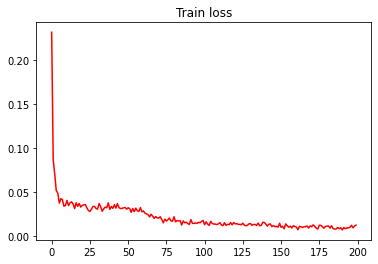

In [ ]:
train_loss = history.history['loss']
plt.plot(train_loss, color='r')
plt.title('Train loss')

***
Prediction

In [ ]:
# Defining test set
test_set = df[first_row-ts:]
test_set.shape

(50, 9)

In [ ]:
# Scaling the test set
test_set_scaled = pd.DataFrame(scaler.transform(test_set), columns=cols + ['sale'])
print(test_set_scaled.shape)
test_set_scaled.tail(2)

(50, 9)


,year,month,day,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,sale
48,1.0,-1.75,0.633333,0.833333,-2.0,-1.982301,0.266667,-2.0625,NaN
49,1.0,-1.75,0.666667,1.000000,-2.0,-1.973451,0.300000,-2.0625,NaN


In [ ]:
# Preparing X_test and predicting speed2
len = test_set.shape[0]
X_test = []

for i in range(ts, len):
  X_test.append(test_set_scaled.loc[i-ts:i, cols].to_numpy())

X_test = np.array(X_test)
print(X_test.shape)

(30, 21, 8)


In [ ]:
y_test = regressor.predict(X_test)
y_test = np.array(y_test)
y_test = y_test.reshape((1,-1))
y_test.shape

(1, 30)

In [ ]:
test_set_scaled.loc[ts:, 'sale'] = y_test
test_set_scaled.tail(2)

,year,month,day,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,sale
48,1.0,-1.75,0.633333,0.833333,-2.0,-1.982301,0.266667,-2.0625,0.278650
49,1.0,-1.75,0.666667,1.000000,-2.0,-1.973451,0.300000,-2.0625,0.329008


In [ ]:
predicted = pd.DataFrame(scaler.inverse_transform(test_set_scaled), columns= cols+['sale'])
predicted = predicted.loc[ts:, 'sale']

In [ ]:
p = pd.DataFrame(round(predicted))
p.reset_index(inplace = True) 
p.head()

,index,sale
0,20,346.0
1,21,347.0
2,22,351.0
3,23,355.0
4,24,357.0


In [ ]:
df_test['sale'] = p['sale']
df_test

,date,sale
0,1399-09-22,346.0
1,1399-09-23,347.0
2,1399-09-24,351.0
3,1399-09-25,355.0
4,1399-09-26,357.0
5,1399-09-27,354.0
6,1399-09-28,342.0
7,1399-09-29,317.0
8,1399-09-30,287.0
9,1399-10-01,268.0


In [ ]:
df_test.to_csv('output.csv', index=False)